# Preprocessing 
#### This file includes preprocessing steps and their plots for sleep stage classification.

Labels come from 2 different PSG systems: Remlogic and Somnomedics. Sleep stage labels are as follows:

0 = Awake = SLEEP-S0 \
1 = REM   = SLEEP-REM \
2 = Light = SLEEP-S1 and  SLEEP-S2 \
3 = Deep  = SLEEP-S3 

EMFIT is the piezoelectric mat and Somnofy is the radar.

## Imports and Loading

In [1]:
import pandas as pd
import numpy as np
from loader import *
import matplotlib.pyplot as plt
from constants import *
from plot import *
from helpers import *

In [2]:
#  skip indices = [27, 34] 
subjectID = PARTICIPANT_IDS[0]
len(PARTICIPANT_IDS)

39

In [3]:
sleep_stages = read_patient_data(subjectID)

In [4]:
sleep_stages.isna().sum()

sleep_stage_num_somnofy    232
sleep_stage_num_emfit       23
sleep_stage_num_psg          1
dtype: int64

In [5]:
sleep_stages.head()

,sleep_stage_num_somnofy,sleep_stage_num_emfit,sleep_stage_num_psg
timestamp_local,,,
2021-08-18 20:19:30+00:00,0.0,NaN,0.0
2021-08-18 20:20:00+00:00,0.0,NaN,0.0
2021-08-18 20:20:30+00:00,NaN,NaN,0.0
2021-08-18 20:21:00+00:00,0.0,NaN,0.0
2021-08-18 20:21:30+00:00,0.0,NaN,0.0


<AxesSubplot:xlabel='timestamp_local'>

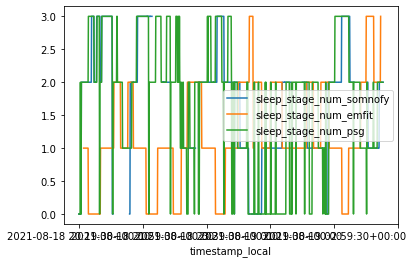

In [6]:
sleep_stages.plot()

<AxesSubplot:xlabel='timestamp_local'>

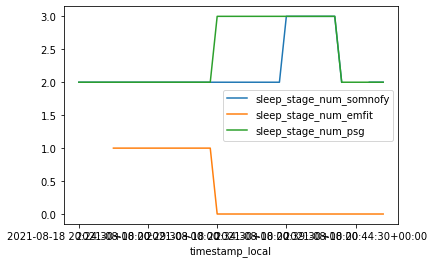

In [7]:
sleep_stages[10:55].plot()

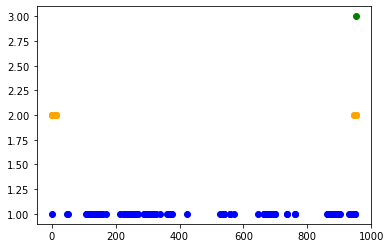

In [8]:
plot_missing_sleepstages(sleep_stages)

## Imputing missing values
Comparison of three main techniques for time series data:
1. coping the previous or future value
2. having a rolling average and rounding it
3. Interpolation with "linear", "spline", "time", "quadratic"

In [9]:
df = pd.DataFrame()
df["somnofy"] = sleep_stages["sleep_stage_num_somnofy"]
df["truth"] = sleep_stages["sleep_stage_num_psg"]
df["Forward Fill"] = df["somnofy"].ffill()
df["Backward Fill"] = df["somnofy"].bfill()

<AxesSubplot:xlabel='timestamp_local'>

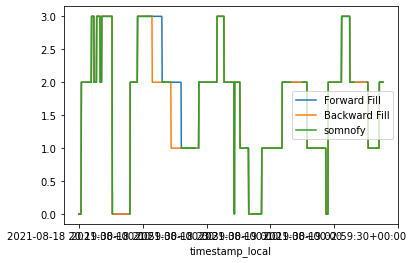

In [10]:
df[["Forward Fill", "Backward Fill", "somnofy"]].plot()

<AxesSubplot:xlabel='timestamp_local'>

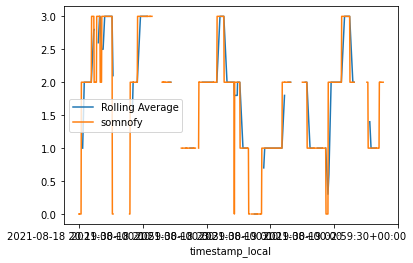

In [11]:
df["Rolling Average"] = df["somnofy"].rolling(window=10).mean()
df[["Rolling Average", "somnofy"]].plot()

<AxesSubplot:xlabel='timestamp_local'>

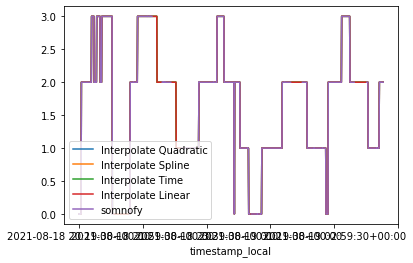

In [12]:
df["Interpolate Spline"]= df["somnofy"].interpolate(option='spline').round()
df["Interpolate Linear"]= df["somnofy"].interpolate(option='linear').round()
df["Interpolate Time"]= df["somnofy"].interpolate(option='time').round()
df["Interpolate Quadratic"]= df["somnofy"].interpolate(option='quadratic').round()
df[["Interpolate Quadratic", "Interpolate Spline", "Interpolate Time", "Interpolate Linear", "somnofy"]].plot()

In [13]:
# no difference between interpolation methods
diff = np.ones(3)
diff[0] = np.linalg.norm(df["somnofy"].interpolate(option='spline')-df["somnofy"].interpolate(option='linear'))
diff[1] = np.linalg.norm(df["somnofy"].interpolate(option='spline')-df["somnofy"].interpolate(option='time'))
diff[2] = np.linalg.norm(df["somnofy"].interpolate(option='spline')-df["somnofy"].interpolate(option='quadratic'))
diff

array([0., 0., 0.])

array([25.78759392, 25.11971337, 26.        ])

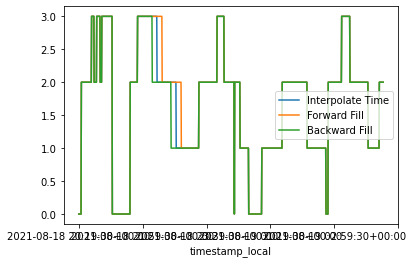

In [15]:
# decide which is best based on ground truth
df[["Interpolate Time", "Forward Fill", "Backward Fill"]].plot()
diff = np.ones(3)
diff[0] = np.linalg.norm(df["Interpolate Time"]-df["truth"].interpolate(option='time').round())
diff[1] = np.linalg.norm(df["Forward Fill"]-df["truth"].ffill())
diff[2] = np.linalg.norm(df["Backward Fill"]-df["truth"].ffill())
diff

In [16]:
test_imputing()

array([38.,  1.,  0.])

In [17]:
impute_all()

[[                           sleep_stage_num_somnofy  sleep_stage_num_emfit  \
  timestamp_local                                                             
  2021-08-18 20:19:30+00:00                      0.0                    1.0   
  2021-08-18 20:20:00+00:00                      0.0                    1.0   
  2021-08-18 20:20:30+00:00                      0.0                    1.0   
  2021-08-18 20:21:00+00:00                      0.0                    1.0   
  2021-08-18 20:21:30+00:00                      0.0                    1.0   
  ...                                            ...                    ...   
  2021-08-19 04:14:00+00:00                      2.0                    3.0   
  2021-08-19 04:14:30+00:00                      2.0                    3.0   
  2021-08-19 04:15:00+00:00                      2.0                    3.0   
  2021-08-19 04:15:30+00:00                      2.0                    3.0   
  2021-08-19 04:16:00+00:00                      2.0